In [1]:
from scipy import linalg
import json
import h5py
import os
import plot_SNVM_data as pSd
import SNVM_B_xyz_extraction as SBex
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib_scalebar.scalebar import ScaleBar
from math import ceil,floor,pi
import colorsys
import cv2
from skimage.util.shape import view_as_blocks
from skimage.io import imsave
from scipy.optimize import curve_fit
import scipy.odr as odr
import scipy.special
import warnings
from sklearn.preprocessing import normalize

In [2]:
def exponential(t,A0,tau,t0,C):
    return A0*np.exp(-(t-t0)/tau)+C
def exponentialNot0(t,A0,tau,C):
    return A0*np.exp(-(t)/tau)+C
#def odrexp(B,t):
#    return B[0]*np.exp(-(t-B[2])/B[1])+B[3]
def odrexp(B,t):
    return B[0]*np.exp(-(t)/B[1])+B[2]
def twotopow(t,A0,tau,t0,C):
    return A0*np.power(2,(-(t-t0)/tau))+C
def tentopow(t,A0,tau,t0,C):
    return A0*np.power(10,(-(t-t0)/tau))+C
def fiftytopow(t,A0,tau,t0,C):
    return A0*np.power(50,(-(t-t0)/tau))+C
def logofexpNot0(t,A0,tau,C):
    return np.log(A0*np.exp(-(t)/tau)+C)
def logofexp(t,A0,tau,t0,C):
    return np.log(A0*np.exp(-(t-t0)/tau)+C)
def noCexp(t,A0,tau):
    return(A0*np.exp(-t/tau))
def gaussian_pdf(x,sigma,mu):
    return(1/(sigma*np.sqrt(2*np.pi))*np.exp((x-mu)**2/(2*sigma**2)))
def gaussian(x,x0,a,b):
    return(a*np.exp((x-x0)**2/(2*b**2)))
def poisson(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))/scipy.special.factorial(x-x0)*np.exp(-lam))
def poissonNoFact(x,lam,a,x0):
    return(a*np.power(lam,(x-x0))*np.exp(-lam))

In [3]:
# List all items in basepath
basepath = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG'
basepath_folders = []
basepath_foldernames = []

for i in range(len(os.listdir(basepath))):
    if os.path.isdir(basepath+'/'+sorted(os.listdir(basepath))[i]):
        basepath_folders.append(basepath+'/'+sorted(os.listdir(basepath))[i])
        basepath_foldernames.append(sorted(os.listdir(basepath))[i])
print(basepath_foldernames)


for i in range(len(basepath_folders)):
        
    if basepath_foldernames[i] =='Magnetometry scans':
        Magnetometry_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Magnetometry_Scans','\n',sorted(os.listdir(basepath_folders[i])))
        
    if basepath_foldernames[i] =='Pulse experiments':
        Pulse_exp_dayfolders = [basepath_folders[i]+'/'+s for s in sorted(os.listdir(basepath_folders[i]))]
        print('Pulse_Experiments','\n',sorted(os.listdir(basepath_folders[i])))
        

['AFM Scans', 'Confocal Scans', 'Magnetometry scans', 'Pulse Programs', 'Pulse experiments', 'Vector Magnet', 'logs']
Magnetometry_Scans 
 ['2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26']
Pulse_Experiments 
 ['2023-09-22', '2023-09-23', '2023-09-24', '2023-09-25', '2023-09-26']


/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/4233145400.py:83: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig_temp = plt.figure()


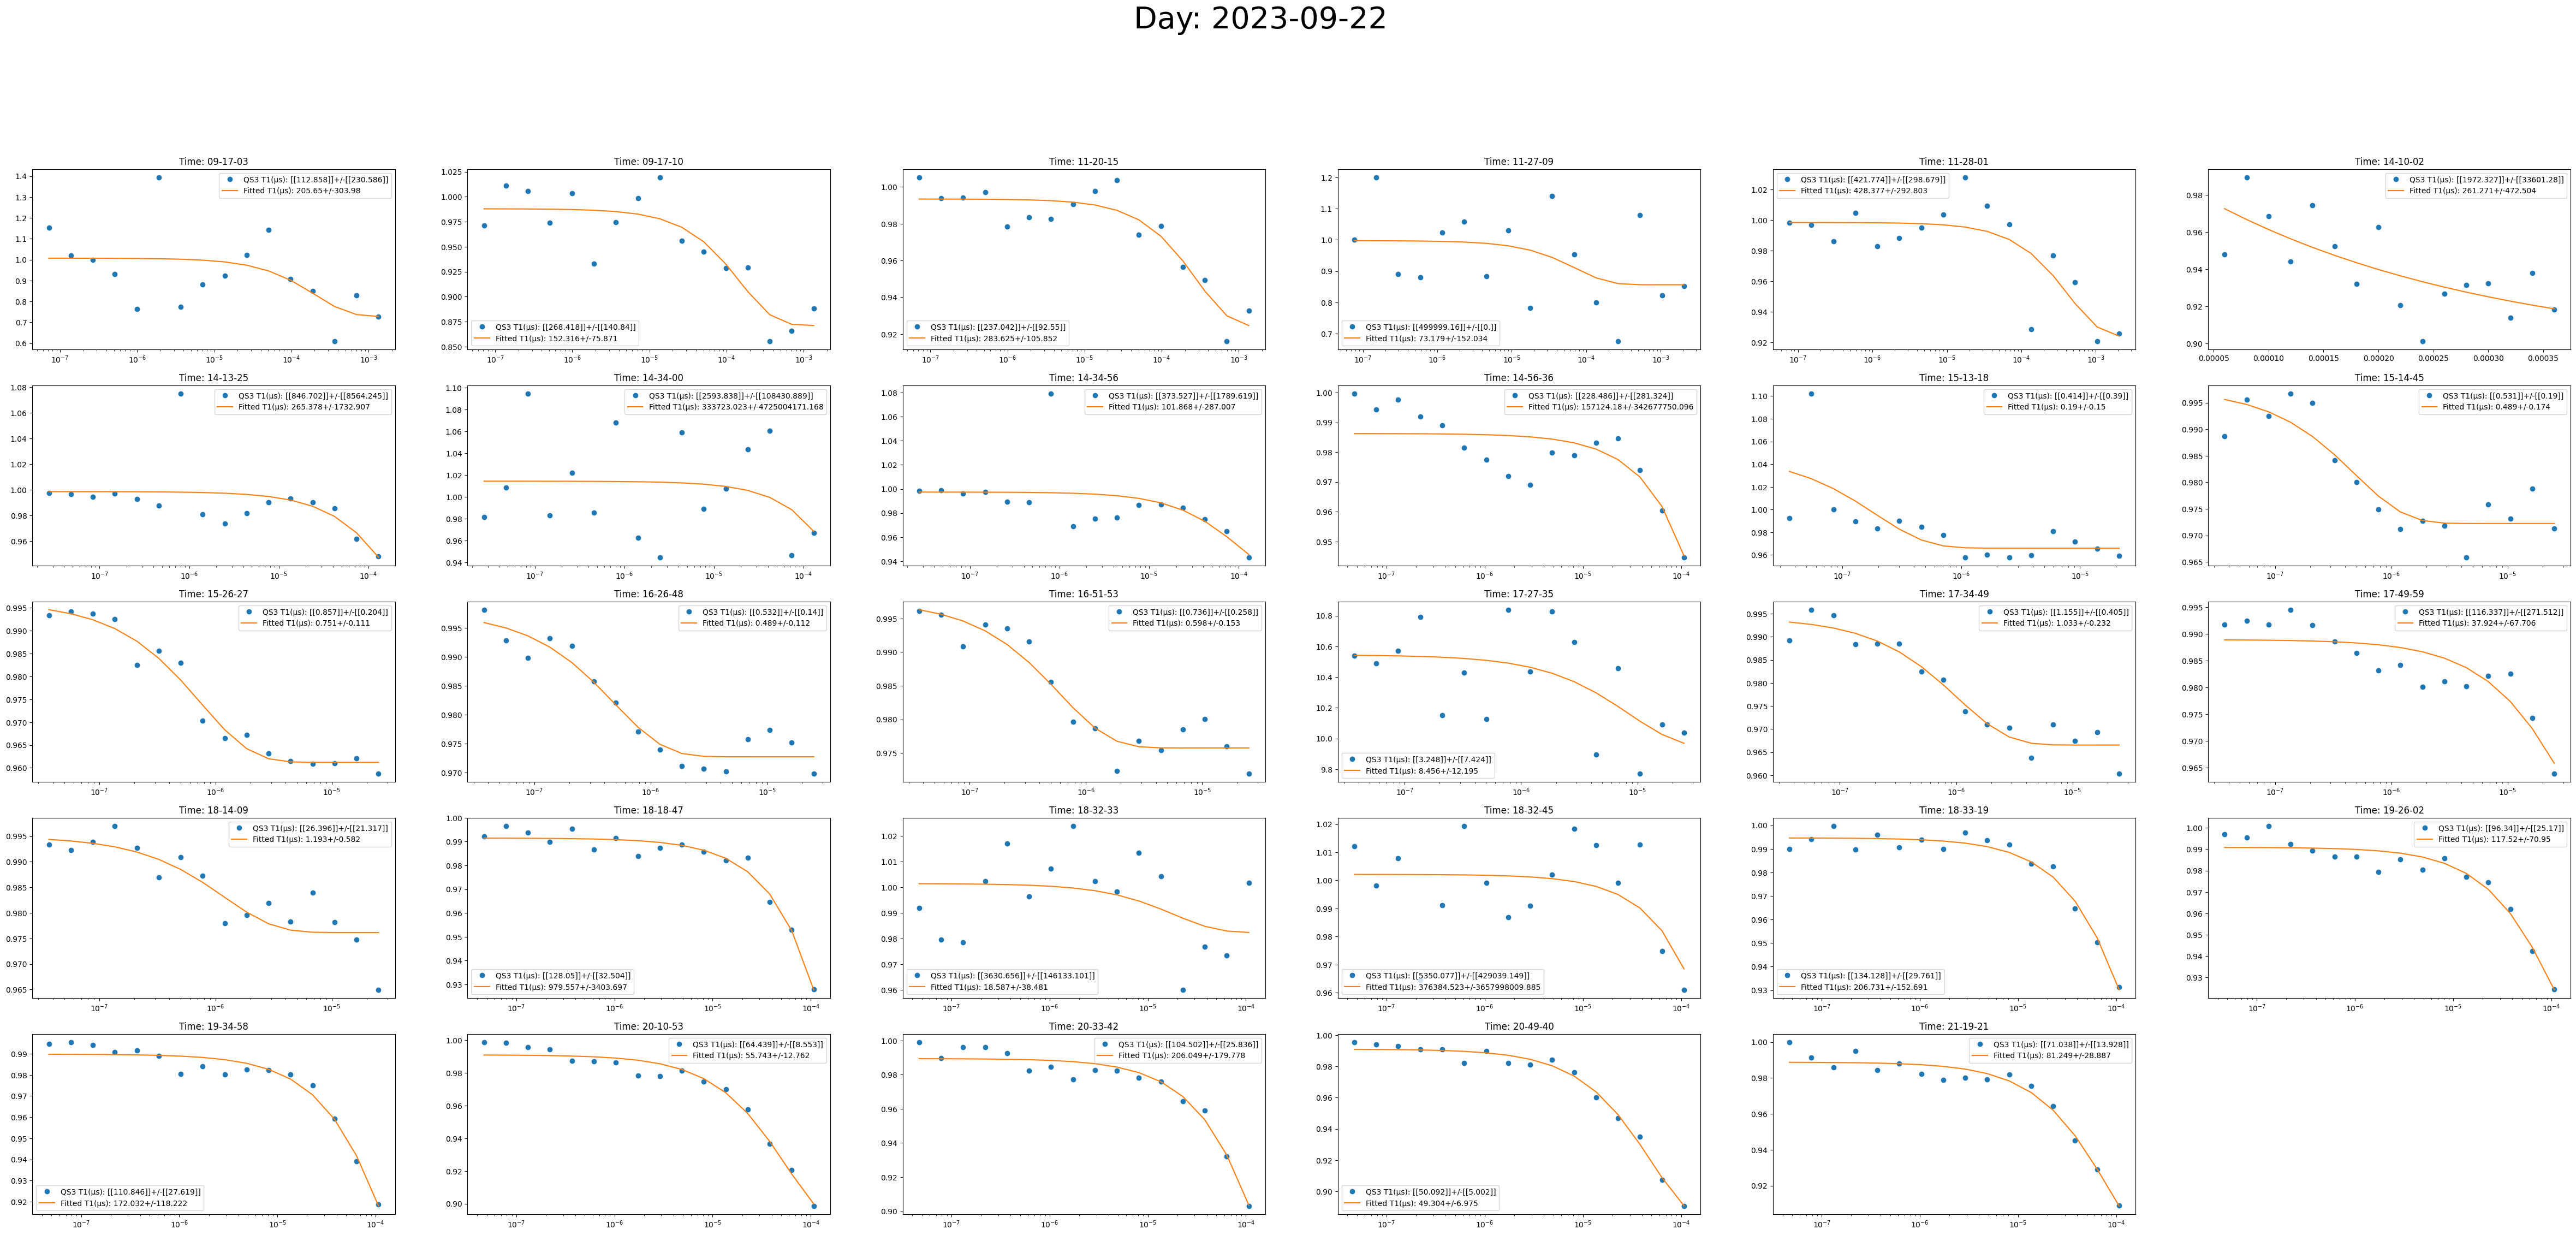

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

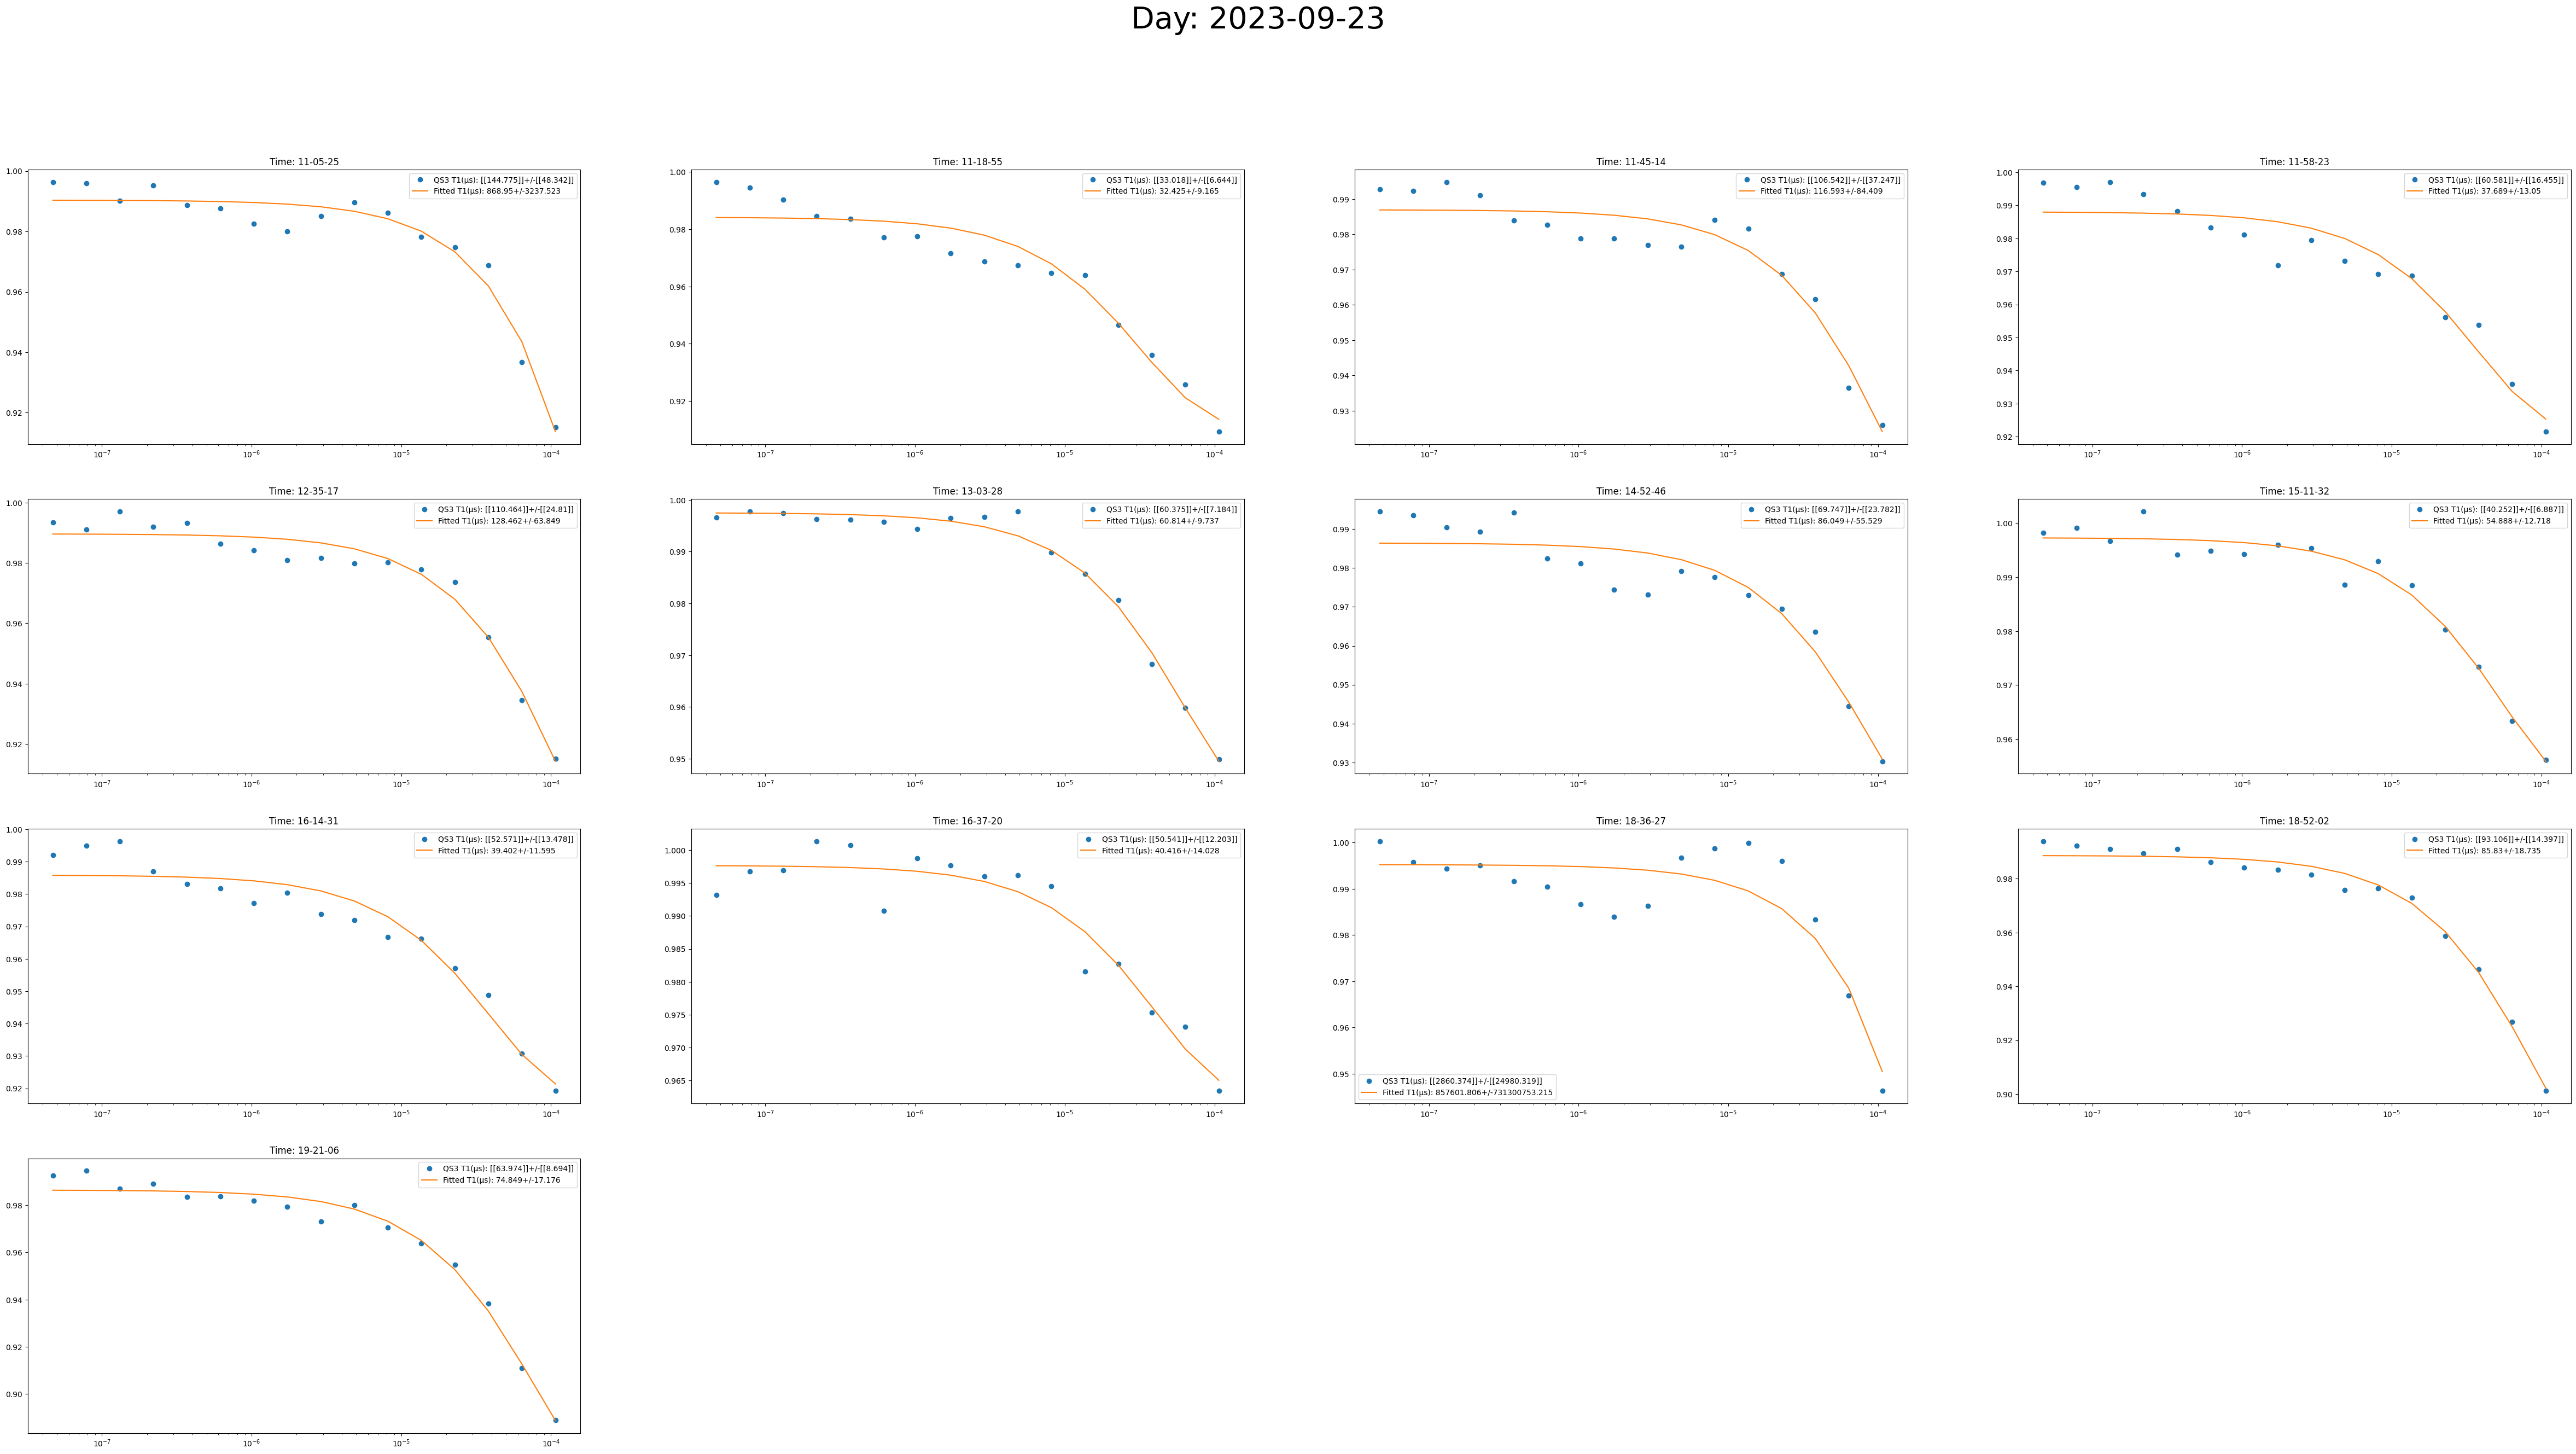

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

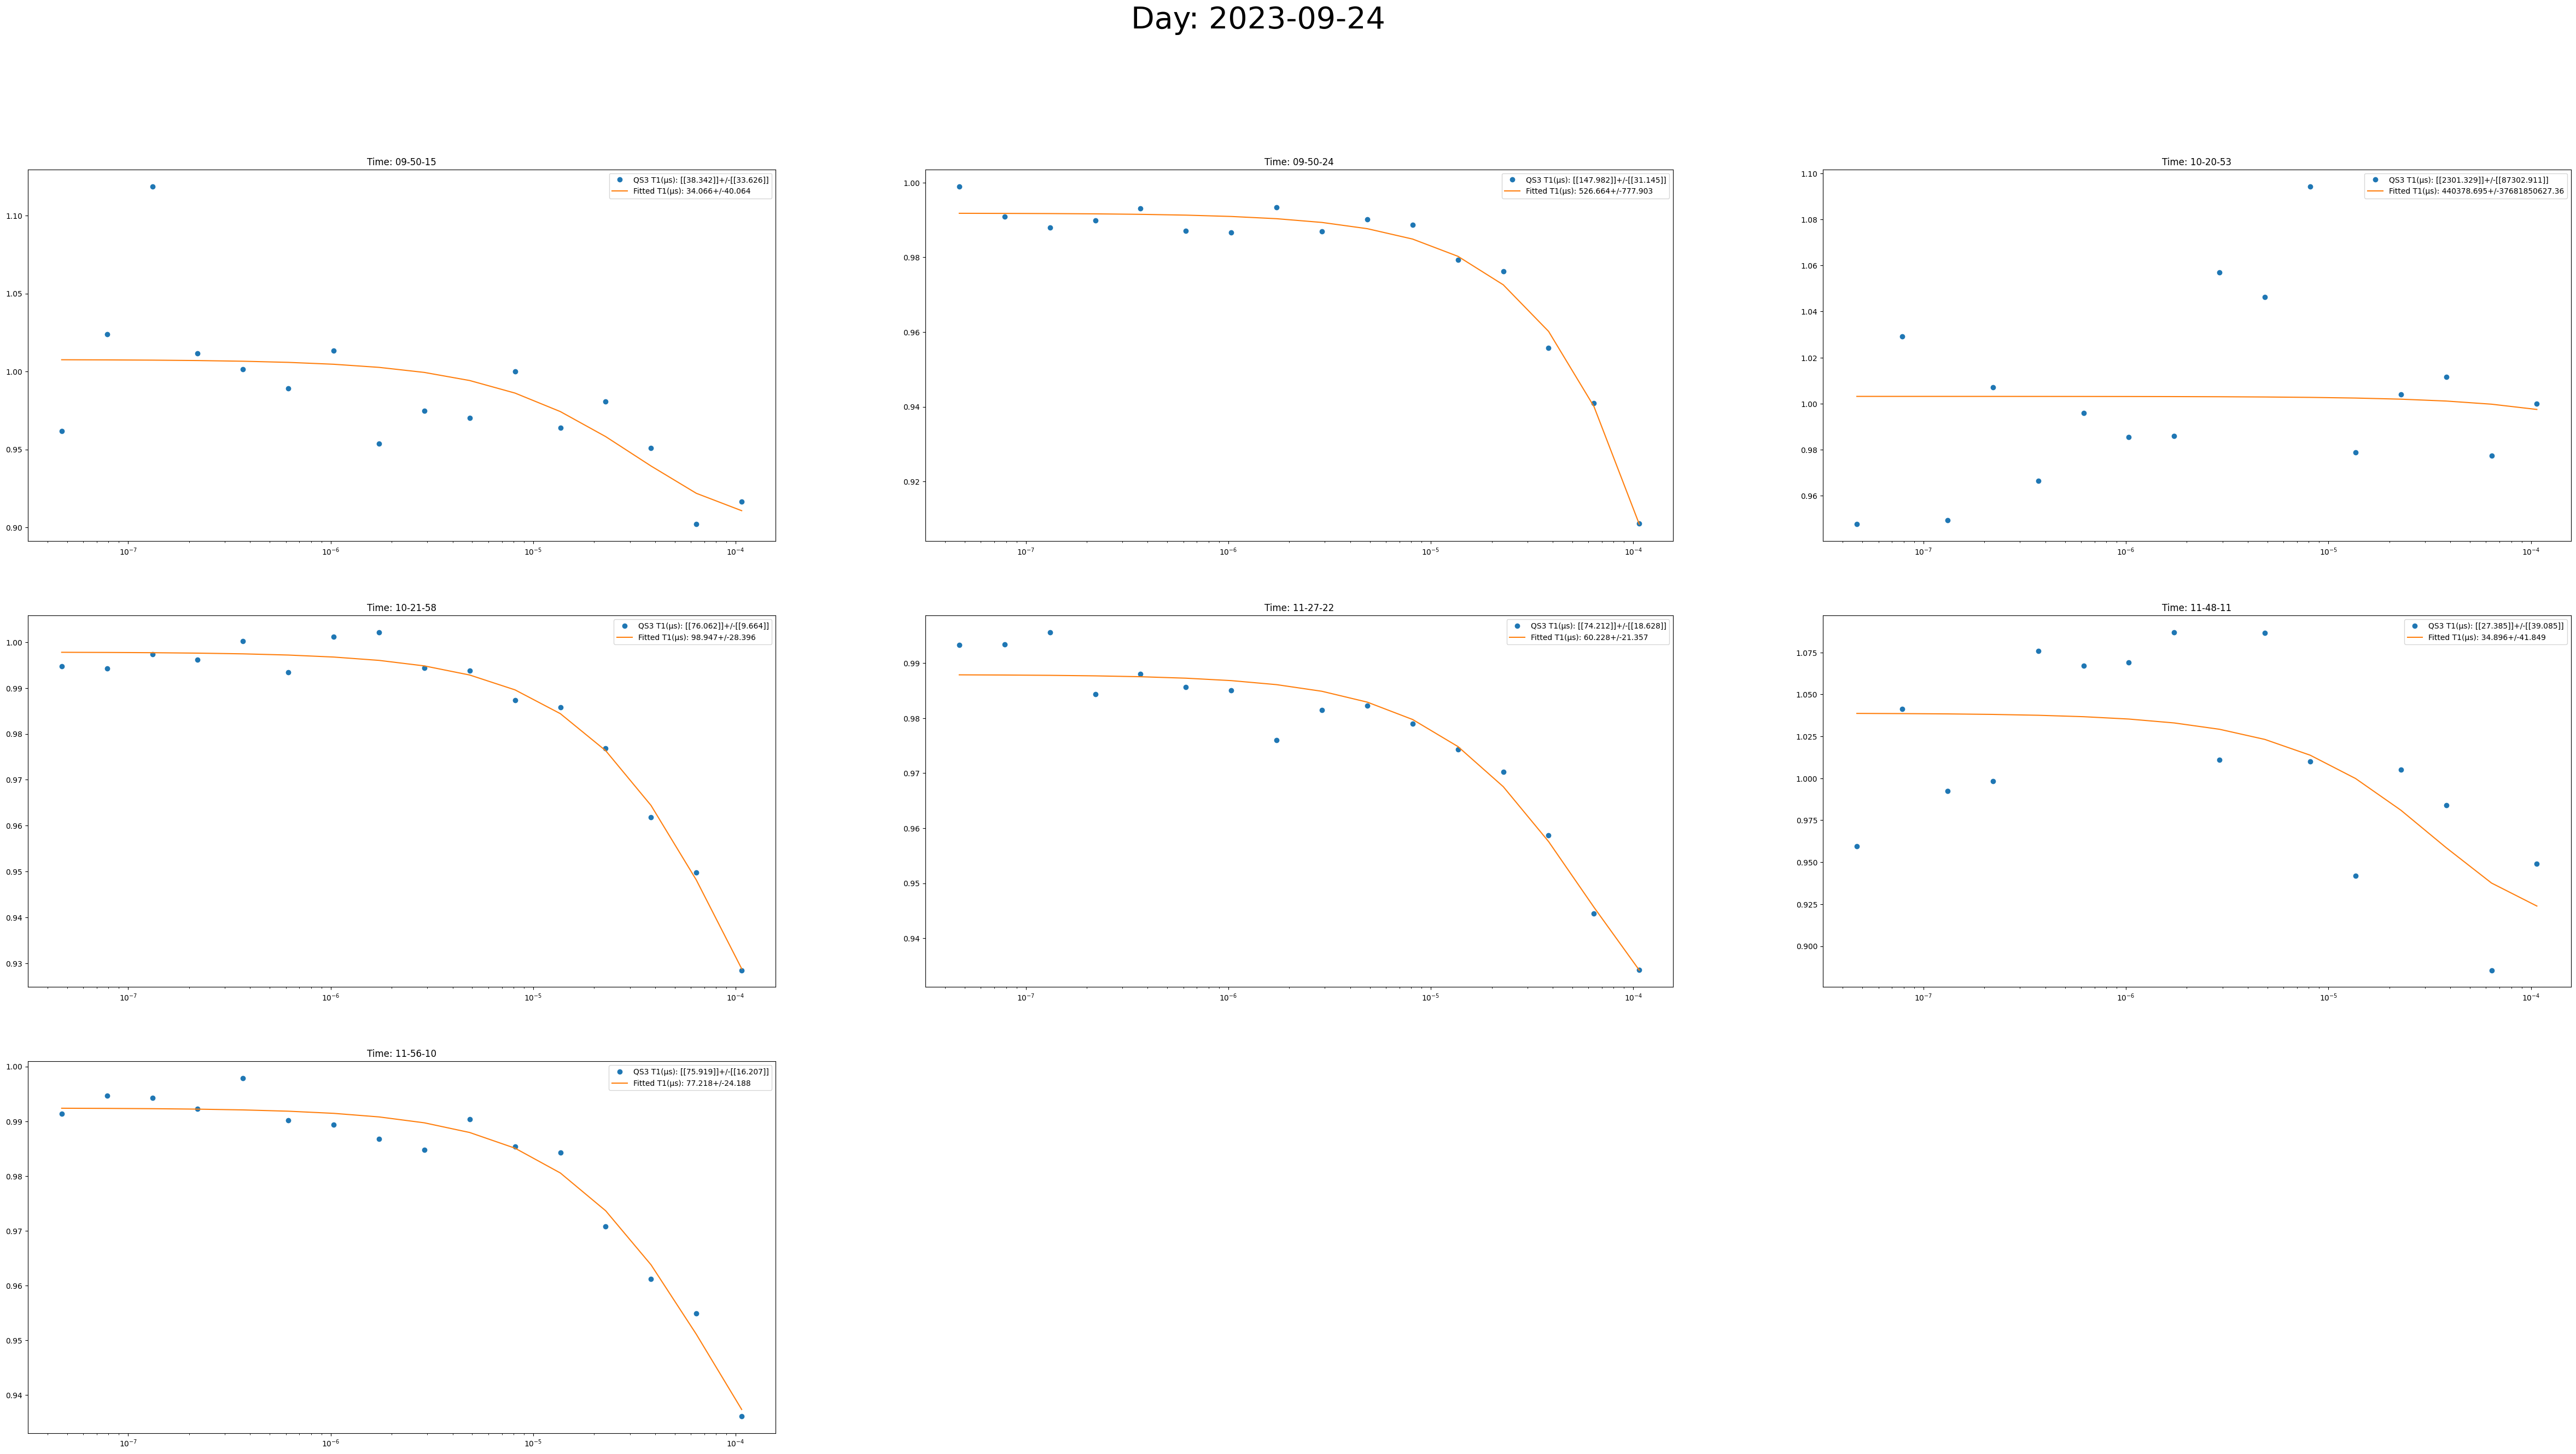

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

<Figure size 6000x3000 with 0 Axes>

In [4]:
#read and plot all pulse experiment data 

savefolder = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/20230922_QZabre_Analysis/Relaxometry'

Pulse_exp_folders = len(Pulse_exp_dayfolders)*[[]]

for Pulse_exp_dayfolders_index in range(len(Pulse_exp_dayfolders)):
    if os.path.isdir(Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]+'/relaxation_laser'):
        Pulse_exp_folders[Pulse_exp_dayfolders_index] = [Pulse_exp_dayfolders[Pulse_exp_dayfolders_index]
                                                        +'/relaxation_laser/'+s 
                                                         for s in sorted(os.listdir(Pulse_exp_dayfolders[
                                                             Pulse_exp_dayfolders_index]+'/relaxation_laser'))]
        #print('\n')
        #print(Pulse_exp_folders[Pulse_exp_dayfolders_index])

nr_of_meas = 0
for day_index in range(len(Pulse_exp_folders)):
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        nr_of_meas+=1

fig_arr = []
nr_meas_perday = []

x_min_px = 3
x_max_px = 19

for day_index in range(len(Pulse_exp_folders)):
    
    #print(len(Pulse_exp_folders[day_index]),Pulse_exp_dayfolders[day_index])
    nr_meas_perday.append(len(Pulse_exp_folders[day_index]))
    fig = plt.figure(figsize = (60,30))
    plt.suptitle('Day: ' + str(Pulse_exp_dayfolders[day_index][-10:]),fontsize=40)
    fig_arr.append(fig)
    
    for measurement_index in range(len(Pulse_exp_folders[day_index])):
        #print(Pulse_exp_folders[day_index][measurement_index])
        h5file = h5py.File(Pulse_exp_folders[day_index][measurement_index]+'/seq0/eval/relaxation.h5')
        
        delays = pSd.ExtractData(h5file, datatype = 'delay')[0][0]
        ms0s = pSd.ExtractData(h5file, datatype = 'ms0')[0][0]
        ref0s = pSd.ExtractData(h5file, datatype = 'ref0')[0][0]
        contrasts = pSd.ExtractData(h5file, datatype = 'contrastms0')[0][0]
        
        if not np.isnan(contrasts).any():
            if not np.isinf(contrasts).any():
                if len(contrasts)>4:
                    p0 = [1/8,3e-4,0.9]
                    lowerbounds = [-np.inf,0,-np.inf]
                    upperbounds = [np.inf,np.inf,np.inf]
                    try:
                        popt, pcov = curve_fit(exponentialNot0,delays[x_min_px:x_max_px], contrasts[x_min_px:x_max_px],p0=p0,bounds=[lowerbounds,upperbounds])
                    except:
                        pass
                    ax = fig.add_subplot(ceil(np.sqrt(nr_meas_perday[day_index])),
                                         ceil(np.sqrt(nr_meas_perday[day_index])),
                                         measurement_index+1)
                    ax.set_title('Time: ' + str(Pulse_exp_folders[day_index][measurement_index][-25:-17]))
                    #plt.plot(np.logspace(-6,-2,200),exponential(np.logspace(-6,-2,200),*popt),'-')
                    QS3_file, metadata = pSd.ReadSNVMfile(Pulse_exp_folders[day_index][measurement_index])
                    if 'relaxationParameters' in metadata:
                        delaytime_scaling = metadata['relaxationParameters']['sampling']
                        #print(delaytime_scaling)
                        if delaytime_scaling == 0:
                            ax.set_xscale('log')
                    T1_QS3 = np.round(QS3_file['data']['relaxation:t1']*1e6,3)
                    T1_err_QS3 = np.round(QS3_file['data']['relaxation:t1_err']*1e6,3)
                    T1_fit = np.round(popt[1]*1e6,3)
                    T1_err_fit = np.round(np.sqrt(np.diag(pcov))[1]*1e6,3)
                    ax.plot(delays[x_min_px:x_max_px],contrasts[x_min_px:x_max_px],'o',label='QS3 T1(µs): '+str(T1_QS3)+'+/-'+str(T1_err_QS3))
                    ax.plot(delays[x_min_px:x_max_px],exponentialNot0(delays[x_min_px:x_max_px],*popt),'-',label='Fitted T1(µs): '+str(T1_fit)+'+/-'+str(T1_err_fit))
                    #ax.plot(np.logspace(-7,-3,len(contrasts)),contrasts[:],'o',label='QS3 T1: '+str(QS3_file['data']['Relaxation:t1']))
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-',label='Fitted T1: '+str(popt[1]))
                    ax.legend()
                    #ax.plot(np.logspace(-7,-3,200),exponential(np.logspace(-7,-3,200),*popt),'-')
                    
                    #min_array = np.where(exponential(delays[:],*popt)>0.95*np.max(exponential(delays[:],*popt)),True,False)
                    #max_array = np.where(exponential(delays[:],*popt)>1.05*np.min(exponential(delays[:],*popt)),True,False)
                    min_array = np.where(exponentialNot0(np.logspace(-9,-1,200),*popt)>0.95*np.max(exponentialNot0(np.logspace(-9,-1,200),*popt)),True,False)
                    max_array = np.where(exponentialNot0(np.logspace(-9,-1,200),*popt)>1.05*np.min(exponentialNot0(np.logspace(-9,-1,200),*popt)),True,False)
                    #print('min array' , min_array)
                    #print('max array' , max_array)
                    
                    fig_temp = plt.figure()
                    
                    #for tau_index in range(len(min_array)):
                    #    if not min_array[tau_index]:
                    #        #tau_min = delays[tau_index]
                    #        tau_min = np.logspace(-9,-1,200)[tau_index]
                    #        break
                    #
                    #for tau_index in range(len(max_array)):
                    #    if not max_array[tau_index]:
                    #        #tau_max = delays[tau_index]
                    #        tau_max = np.logspace(-9,-1,200)[tau_index]
                    #        break
                    ##print(str(Pulse_exp_folders[day_index][measurement_index][-25:-17]) + ' falling length',
                    ##      tau_max-tau_min)
                        
    #fig.savefig(savefolder + '/' + str(Pulse_exp_dayfolders[day_index][-10:]) + '_AllRelaxometries_logscaled.png',dpi=120)#,transparent=True)
    plt.show()


/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_temp.set_xscale('log')
/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_temp.set_xscale('log')
/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_temp.set_xscale('log')
/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_temp.set_xscale('log')
/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_temp.set_xscale('log')
/run/user/1000/app/org.jupyter.JupyterLab/ipykernel_1248/3540560531.py:55: UserWarning: Data ha

[[54.6252836  35.11803451 76.7009084  66.03631819 98.69419883         nan
          nan 68.70166663]
 [        nan 42.35086752 86.70110134 42.96443339 91.00357859 58.54374232
  61.09386245 71.78126713]
 [69.02976042 78.93189095         nan 83.29645623 53.83980922 71.99559847
  99.30773837 44.46669949]
 [33.88822501 29.71677719 65.01542218 79.95642718 61.57209487 82.25415148
  68.91441256 50.93580529]
 [40.2999374  71.09177283 47.90819108         nan         nan         nan
  51.90809381 52.73478972]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan]]
[[9.70637619e+01 6.89116627e+01 6.86044184e+01 5.74499021e+01
  6.30233039e+01            nan            nan            nan]
 [1.11557808e+02 6.37699839e+01 7.92860356e+01 7.45463738e+01
  6.

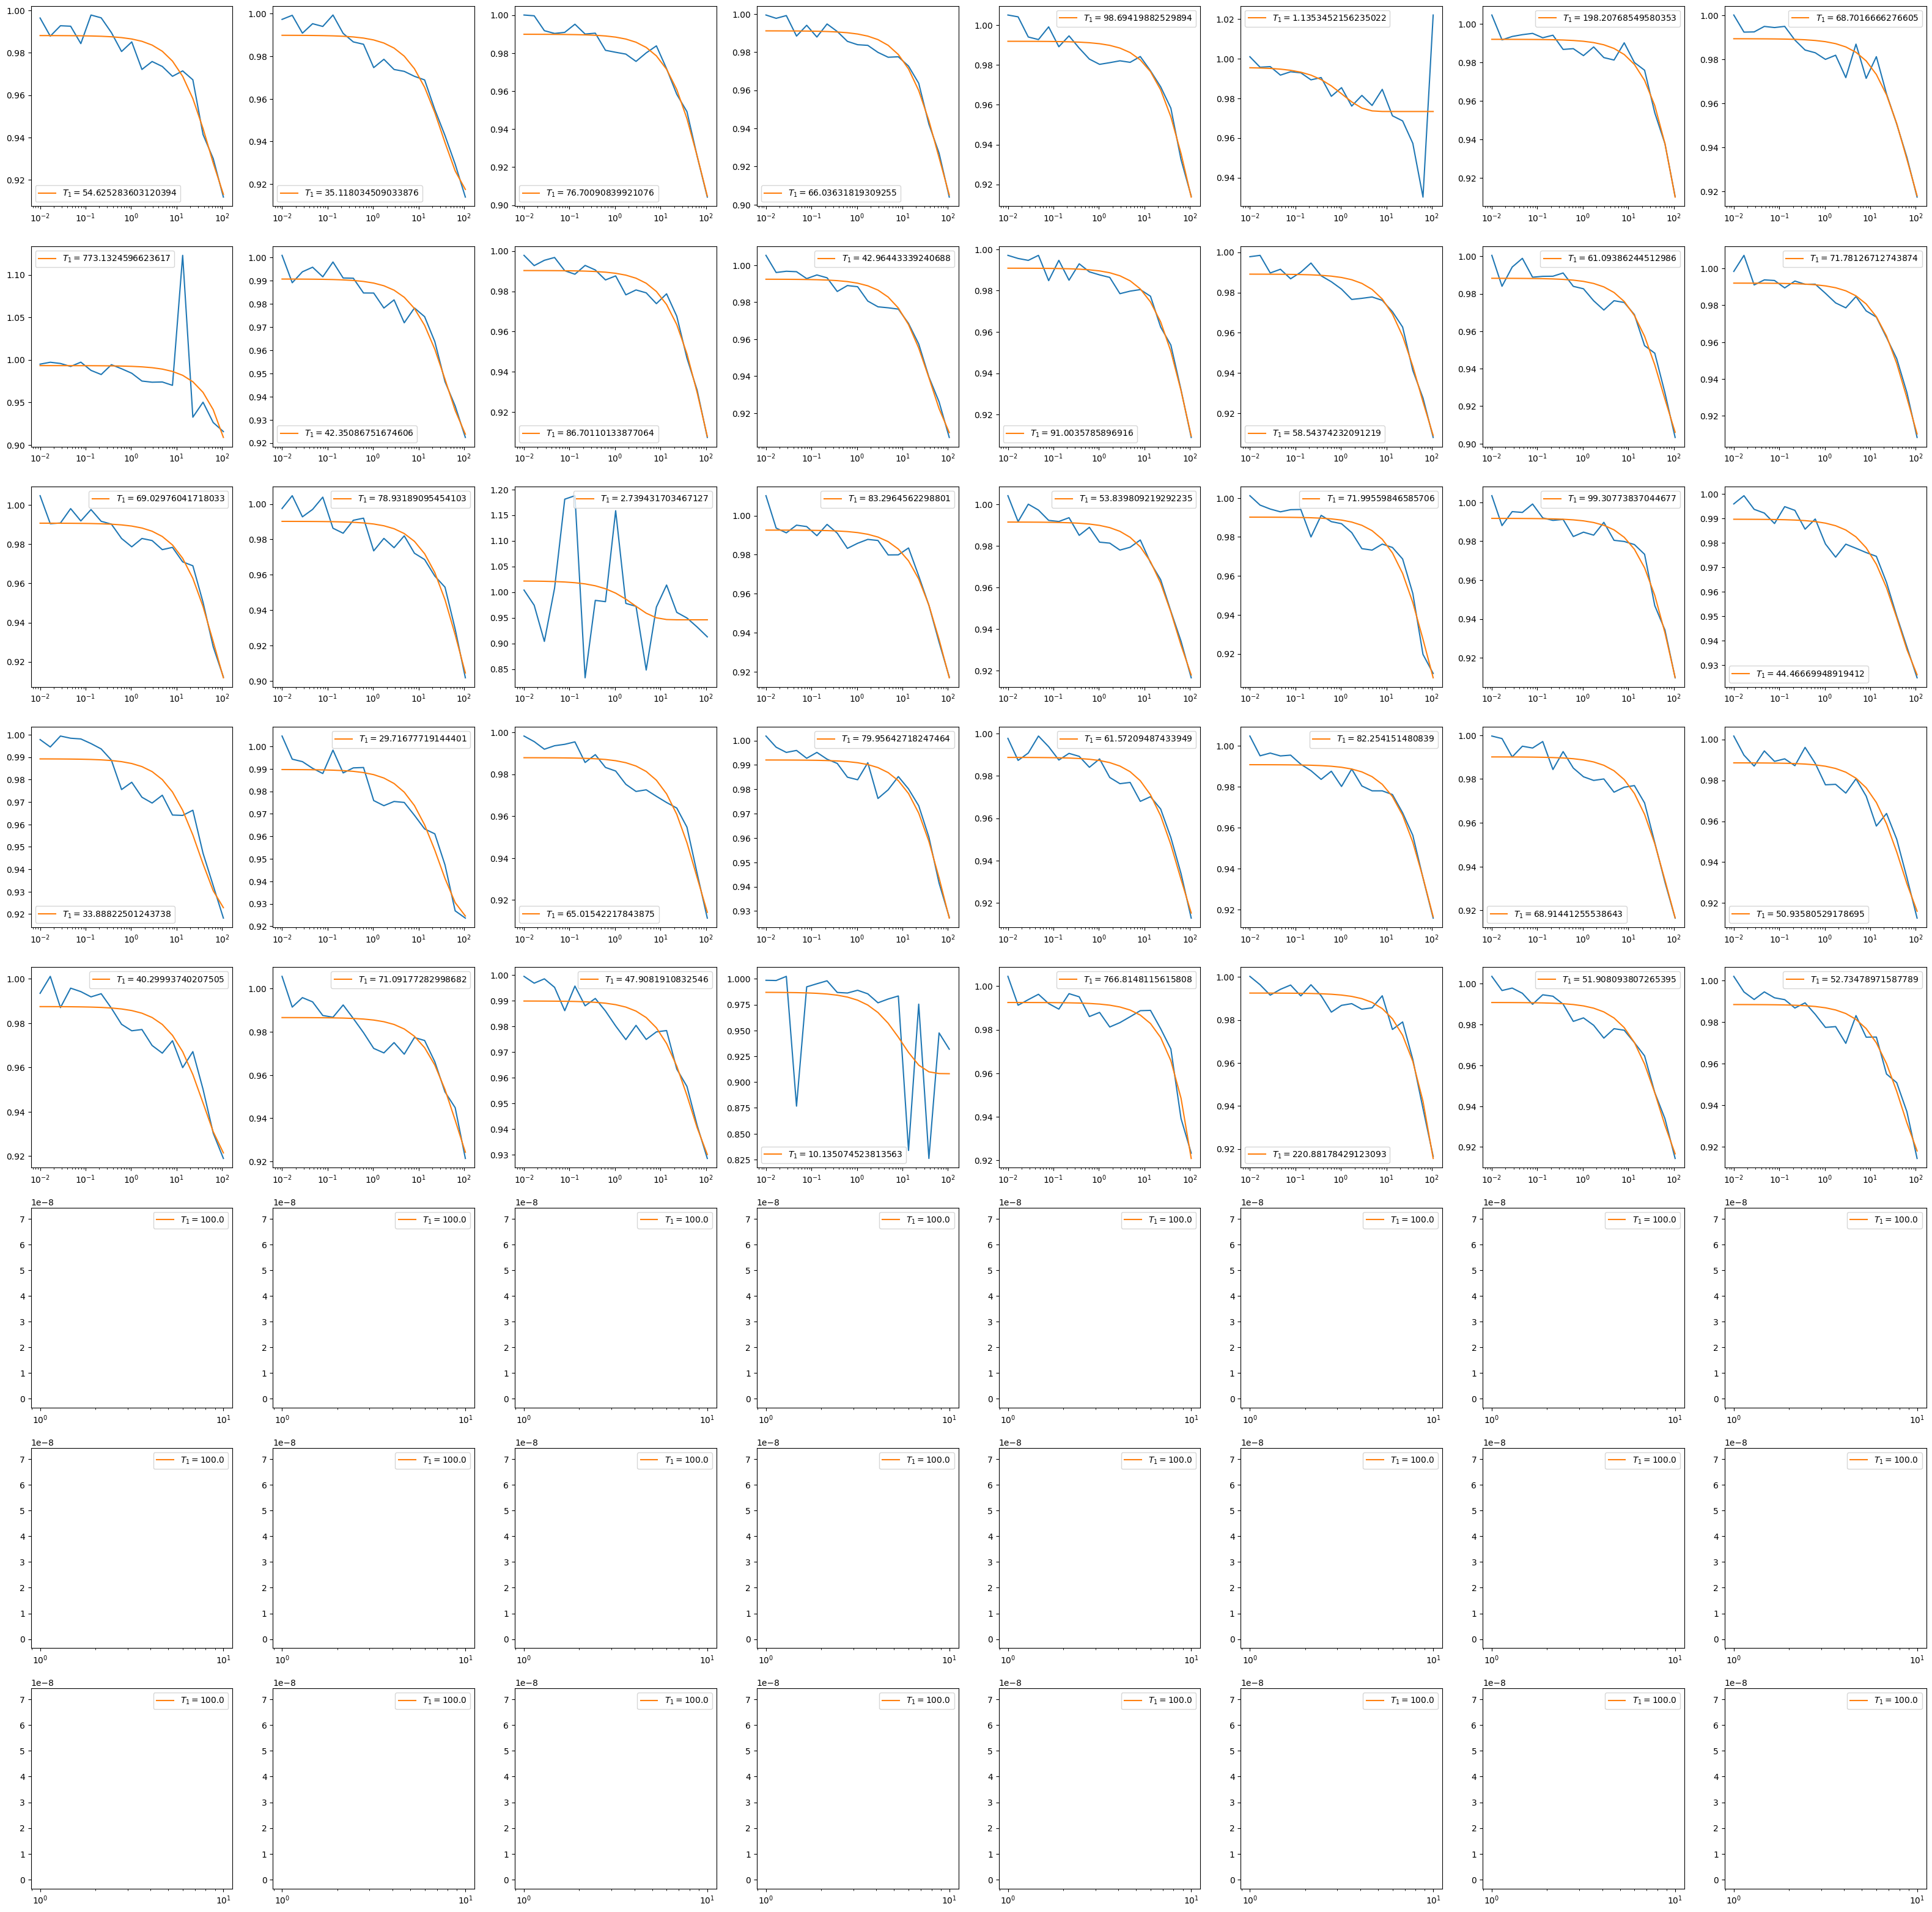

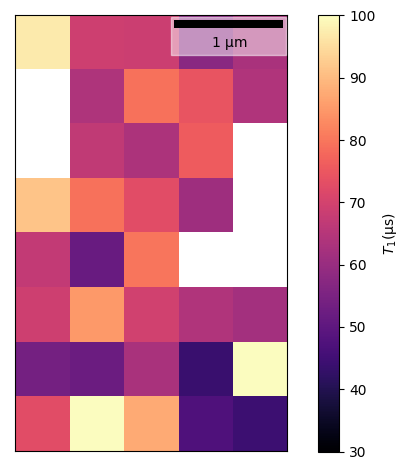

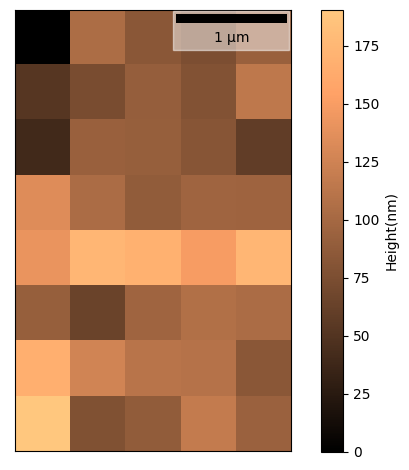

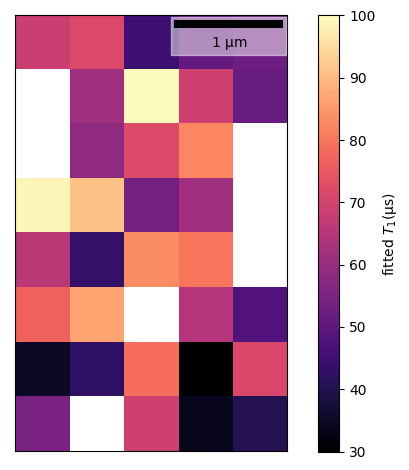

In [5]:
filepath = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG/Magnetometry scans/2023-09-22/relaxation_laser/2023-09-22-21-31-57-relaxation_laser'
file, metadata = pSd.ReadSNVMfile(filepath)

data_topo = pSd.ExtractData(file, datatype = 'afm:height')
data_topo = pSd.AdjustDataToQS3(data_topo)

data_relax = pSd.ExtractData(file, datatype = 'relaxation:t1')
data_relax = pSd.AdjustDataToQS3(data_relax)


fig = plt.figure(figsize = (40,40))

relaxation_filepath = filepath + '/seq0/eval/relaxation.h5'
data_relaxations = h5py.File(relaxation_filepath)['data']
#print(np.shape(data_relaxations))

delays_relaxations = data_relaxations[:,:,:]['delay']*1e6
contrasts_relaxations = data_relaxations[:,:,:]['contrastms0']

x_min_px = 0
x_max_px = 19

fittedT1_relaxations = np.zeros_like(data_relax)

counterj=0
counteri=0
for i in range(np.shape(data_relaxations)[0]):
    #counteri=i
    for j in range(np.shape(data_relaxations)[0]):
        #counterj = j
        #print(i,j,counteri,counterj,counteri+counterj+1)
        try:
            ax_temp = fig.add_subplot((np.shape(data_relaxations)[0]),(np.shape(data_relaxations)[1]),counterj+1)
        except:
            pass
        p0 = [1/8,1e2,0.9]
        lowerbounds = [-np.inf,0,-np.inf]
        upperbounds = [np.inf,np.inf,np.inf]
        try:
            popt, pcov = curve_fit(exponentialNot0,delays_relaxations[i,j,x_min_px:x_max_px], contrasts_relaxations[i,j,x_min_px:x_max_px],
                                   p0=p0,bounds=[lowerbounds,upperbounds])
        except:
            popt=[0,0,0]
        
        if popt[1] < 20:
            fittedT1_relaxations[i,j] = float('Nan')
        elif popt[1] > 110:
            fittedT1_relaxations[i,j] = float('Nan')
        elif popt[1] == 100.0:
            fittedT1_relaxations[i,j] = float('Nan')
        else:
            fittedT1_relaxations[i,j] = popt[1]
        ax_temp.plot(delays_relaxations[i,j,x_min_px:x_max_px],contrasts_relaxations[i,j,x_min_px:x_max_px])
        ax_temp.plot(delays_relaxations[i,j,x_min_px:x_max_px],exponentialNot0(delays_relaxations[i,j,x_min_px:x_max_px],*popt),label=r'$T_1=$'+str(popt[1]))
        ax_temp.set_xscale('log')
        plt.legend()
    
        counterj+=1
        
    counteri+=1
        
    
print(fittedT1_relaxations)
print(data_relax*1e6)

for i in range(np.shape(data_relax)[0]):
    for j in range(np.shape(data_relax)[1]):
        if data_relax[i,j] < 20*1e-6:
            data_relax[i,j] = float('Nan')
        elif data_relax[i,j] > 110*1e-6:
            data_relax[i,j] = float('Nan')

fig_relax, ax_relax, im_relax, cb_relax, scalebar_relax = pSd.PlotData(data_relax[:,:5]*1e6,metadata,datalabel = r'$T_1$(µs)',minval = 30, maxval = 100)

fig_topo, ax_topo, im_topo, cb_topo, scalebar_topo = pSd.PlotData(data_topo[:,:5]*1e9,metadata,cmap='copper',backgroundcorr='y',datalabel='Height(nm)')

fittedT1_relaxations = pSd.AdjustDataToQS3(fittedT1_relaxations)

fig_relaxations, ax_relaxations, im_relaxations, cb_relaxations, scalebar_relaxations = pSd.PlotData(fittedT1_relaxations[:,:5],metadata,datalabel = r'fitted $T_1$(µs)',minval = 30, maxval = 100)



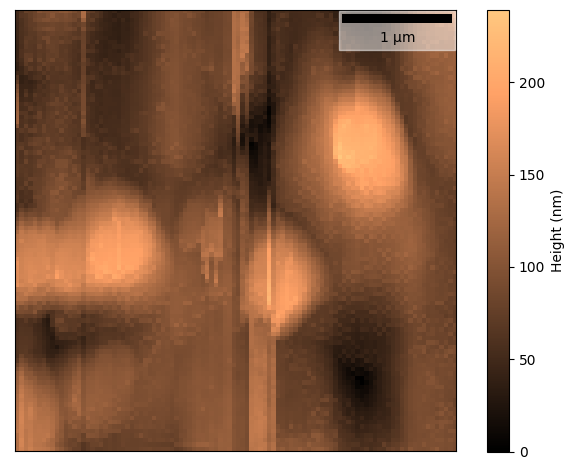

In [6]:
filepath = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG/AFM Scans/2023-09-23/2023-09-23-10-33-19-AFM'

file, metadata = pSd.ReadSNVMfile(filepath)

data_topo = pSd.ExtractData(file, datatype = 'afm:height')
data_topo = pSd.AdjustDataToQS3(data_topo)

fig_topo, ax_topo, im_topo, cb_topo, scalebar_topo = pSd.PlotData(data_topo[:,:]*1e9,metadata,cmap='copper',backgroundcorr='y',datalabel='Height (nm)')



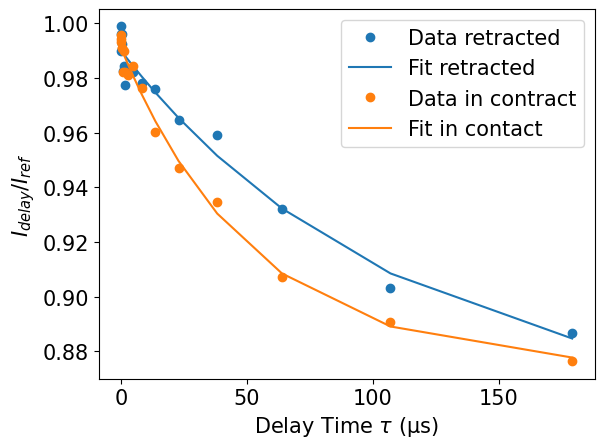

In [23]:
filepath = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG/Pulse experiments/2023-09-22/relaxation_laser/2023-09-22-20-33-42-relaxation_laser'

h5file = h5py.File(filepath+'/seq0/eval/relaxation.h5')
delays = pSd.ExtractData(h5file, datatype = 'delay')[0][0]
ms0s = pSd.ExtractData(h5file, datatype = 'ms0')[0][0]
ref0s = pSd.ExtractData(h5file, datatype = 'ref0')[0][0]
contrasts = pSd.ExtractData(h5file, datatype = 'contrastms0')[0][0]

filepath_reducedT1 = '/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/230922_Visit_QZabre_DyCu5_CoCo4_FeF3_DyIG/Pulse experiments/2023-09-22/relaxation_laser/2023-09-22-20-49-40-relaxation_laser'

h5file_reducedT1 = h5py.File(filepath_reducedT1+'/seq0/eval/relaxation.h5')
delays_reducedT1 = pSd.ExtractData(h5file_reducedT1, datatype = 'delay')[0][0]
ms0s_reducedT1 = pSd.ExtractData(h5file_reducedT1, datatype = 'ms0')[0][0]
ref0s_reducedT1 = pSd.ExtractData(h5file_reducedT1, datatype = 'ref0')[0][0]
contrasts_reducedT1 = pSd.ExtractData(h5file_reducedT1, datatype = 'contrastms0')[0][0]

p0 = [1/8,3e-4,0.9]
lowerbounds = [-np.inf,0,-np.inf]
upperbounds = [np.inf,np.inf,np.inf]
try:
    popt, pcov = curve_fit(exponentialNot0,delays[3:], contrasts[3:],p0=p0,bounds=[lowerbounds,upperbounds])
    popt_reducedT1, pcov_reducedT1 = curve_fit(exponentialNot0,delays_reducedT1[3:], contrasts_reducedT1[3:],p0=p0,bounds=[lowerbounds,upperbounds])
except:
    pass

fig, ax= plt.subplots()
ax.plot(delays[3:]*1e6,contrasts[3:],'o',label='Data retracted',color='C0')
ax.plot(delays[3:]*1e6,exponentialNot0(delays[3:],*popt),'-',label=r'Fit retracted',color='C0')#ted $T_1$: ('+str(np.round(popt[1]*1e6,2))+r'$\pm$'+str(np.round(np.sqrt(np.diag(pcov))[1]*1e6,3))+') µs')
ax.plot(delays_reducedT1[3:]*1e6,contrasts_reducedT1[3:],'o',label='Data in contract',color='C1')
ax.plot(delays_reducedT1[3:]*1e6,exponentialNot0(delays_reducedT1[3:],*popt_reducedT1),'-',label=r'Fit in contact',color='C1')#ted $T_1$: ('+str(np.round(popt[1]*1e6,2))+r'$\pm$'+str(np.round(np.sqrt(np.diag(pcov))[1]*1e6,3))+') µs')
ax.set_xlabel(r'Delay Time $\tau$ (µs)')
ax.set_ylabel(r'${I_{delay}}/{I_{ref}}$')
plt.rc('font', size=15)
plt.rc('axes', titlesize=15)
plt.ylim(bottom=0.87)
#ax.set_xscale('log')
ax.legend()

plt.savefig('/home/julisko/Seafile/My Library/SNVM/20230922_QZabre_Visit_Garnets_SMMs_2DMag/20230922_QZabre_Analysis/Relaxometry/reducedT1_both_linscale.png',bbox_inches = 'tight', dpi=300)

plt.show()

